# Total cases and deaths for several country based on available data

In [425]:
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib widget

### WHO data

In [426]:
# This site consolidate the data from WHO reports daily
who_url = 'https://covid.ourworldindata.org/data/full_data.csv'
who_data = pd.read_csv(who_url)
who_data['source'] = 'who'

# Renaming columns and keeping only those of interests
who_data.drop(columns=['new_cases', 'new_deaths'], inplace=True) # totals are already calculated
who_data.rename(columns={'location':'country'}, inplace=True)

# Name correction...
who_data.loc[who_data.country=='United States', 'country'] = 'U.S.A'

# Date conversion
who_data['date'] = pd.to_datetime(who_data['date'])
who_data.sort_values(by='date', inplace=True)

### ECDC data

In [427]:
# Another sources but no information on data source
ecdc_url = "https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide"
response = get(ecdc_url)

# Since the link changes daily, let's make some soup
soup = BeautifulSoup(response.text, 'html.parser')
ecdc_data_url = soup.find('a', attrs={'href': re.compile("^https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-")}).get('href')

ecdc_data = pd.read_excel(ecdc_data_url)
ecdc_data['source'] = 'ecdc'

# Renaming columns
ecdc_data.rename(columns={'DateRep':'date', 'CountryExp':'country', 'NewConfCases':'new_cases', 'NewDeaths':'new_deaths'}, inplace=True)

# Name correction...
ecdc_data.loc[ecdc_data.country=='United States of America', 'country'] = 'U.S.A'

# Date conversion
ecdc_data['date'] = pd.to_datetime(ecdc_data['date'])
ecdc_data.sort_values(by='date', inplace=True)

# Totals had to be calculated
ecdc_data['total_cases'] = ecdc_data.groupby('country')['new_cases'].cumsum()
ecdc_data['total_deaths'] = ecdc_data.groupby('country')['new_deaths'].cumsum()

# Keeping only those of interests
ecdc_data.drop(columns=['GeoId', 'Gaul1Nuts1', 'EU', 'new_cases', 'new_deaths'], inplace=True)




### Epidemy start offset

Since each country have had different start regarding this epidemy, with dumbly offset the dates by the first case identified in ECDC data (since they have the most history) for each country.
Hence in the following graphs, **day 0** corresponds to the first cases as indicated in ECDC data.

In [428]:
# Looking for first cases
china_start_date = pd.Timestamp('2019-12-31') # For future use
country_start_date_cases = dict(ecdc_data[(ecdc_data.total_cases>0)].groupby('country').head(1)[['country', 'date']].values)

### Merging the data

We merge WHO and ECDC data and add a column with the days since first case for each country.

We only keep the countries appearing in both.

In [429]:
ecdc_data['case_fatality_rate'] = 100*(ecdc_data.total_deaths/ecdc_data.total_cases)
who_data['case_fatality_rate'] = 100*(who_data.total_deaths/who_data.total_cases)


ecdc_data_melt = pd.melt(ecdc_data, 
                         id_vars=['date', 'country', 'source'], 
                         value_vars=['total_cases', 'total_deaths', 'case_fatality_rate'])
who_data_melt = pd.melt(who_data, 
                        id_vars=['date', 'country', 'source'], 
                        value_vars=[ 'total_cases', 'total_deaths', 'case_fatality_rate'])

who_data_world = who_data_melt[who_data_melt.country=='World']
who_data_melt = who_data_melt[who_data_melt.country.isin(ecdc_data_melt.country)]

data = pd.concat([ecdc_data_melt, who_data_melt])
data['offsetted_start_first_case'] = data.apply(lambda x: (x['date'] - country_start_date_cases[x['country']]).days, axis=1)  


## Plots

In [430]:
countries_to_plot = ['France', 'Spain', 'Japan', 'Italy', 'China', 'U.S.A']
data_plot = data[data.country.isin(countries_to_plot)]

### Total cases and deaths since the first case for each country

<IPython.core.display.Javascript object>


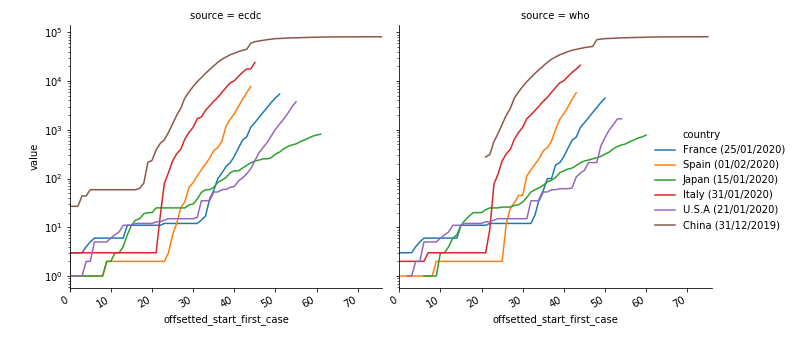

In [431]:
g = sns.relplot(x='offsetted_start_first_case', y='value',
                kind='line',
                hue='country',
                col='source',
                data=data_plot[data_plot.variable=='total_cases'])
g.fig.autofmt_xdate()
g.set(yscale='log')
g.set(xlim=(0,(pd.to_datetime('today')-china_start_date).days))

for t in g._legend.texts[1:]:
    t.set_text("{} ({})".format(t.get_text(), country_start_date_cases[t.get_text()].strftime('%d/%m/%Y')))

plt.show()
plt.savefig('Total_cases.png')

<IPython.core.display.Javascript object>


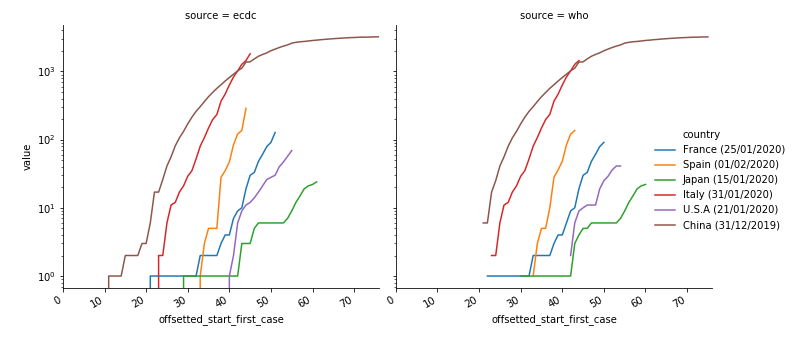

In [432]:
g = sns.relplot(x='offsetted_start_first_case', y='value',
                kind='line',
                hue='country',
                col='source',
                data=data_plot[data_plot.variable=='total_deaths'])
g.fig.autofmt_xdate()
g.set(yscale='log')
g.set(xlim=(0,(pd.to_datetime('today')-china_start_date).days))

for t in g._legend.texts[1:]:
    t.set_text("{} ({})".format(t.get_text(), country_start_date_cases[t.get_text()].strftime('%d/%m/%Y')))

plt.show()
plt.savefig('Total_deaths.png')

### Morbidity

<IPython.core.display.Javascript object>


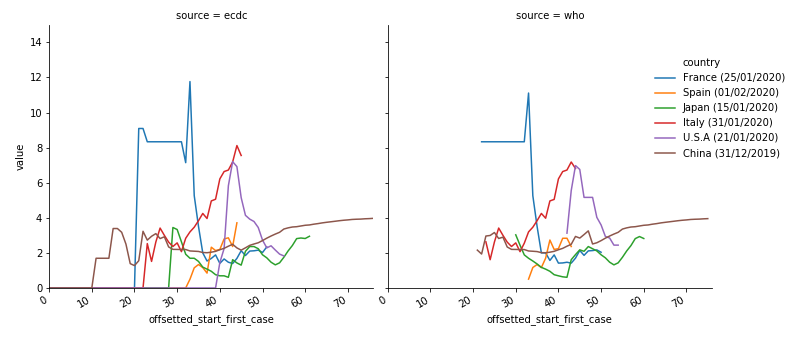

In [433]:
g = sns.relplot(x='offsetted_start_first_case', y='value',
                kind='line',
                hue='country',
                col='source',
                data=data_plot[data_plot.variable=='case_fatality_rate'])
g.fig.autofmt_xdate()
g.set(xlim=(0,(pd.to_datetime('today')-china_start_date).days))
g.set(ylim=(0,15))

for t in g._legend.texts[1:]:
    t.set_text("{} ({})".format(t.get_text(), country_start_date_cases[t.get_text()].strftime('%d/%m/%Y')))
g.fig.get_children()[-1].set_bbox_to_anchor((1, 0.7, 0, 0))

plt.show()
plt.savefig('Morbidity.png')